`DSCI 100 003 Introduction to Data Science   Group 24   December 6, 2025`

In [88]:
###### importing necessary libraries
library(dplyr) 
library(tidyverse)
library(GGally)
library(tidymodels)
library(tidyclust)
library(ISLR)
library(infer)
library(cowplot)
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## **Identifying Player Characterists with High Yield Hours in Multiplayer Gameplay on Minecraft Server**

###### CONTENTS
[Introduction](#introduction)  |  [Methods](#methods)  |  [Results](#results)  |  [Discussion](#discussion)  |  [References](#references)

#### **Introduction**  <a name="introduction"></a>
The Pacific Laboratory of Artificial Intelligence (PLAI) at UBC has set up a free Minecraft server with the goal to record 10,000 hours of multiplayer gameplay [1]. With this goal in mind, this project analyzes individual player data to understand whether PLAI can utilize targeted outreach to maximize average data contribution. This question is addressed with the `players` data; the `sessions` data is ignored due to it's lack of player specific characteristics. 

In [4]:
# loading players.csv data
  players <- read_csv("https://raw.githubusercontent.com/vicky-nak/DSCI-Final-Report-24/refs/heads/main/players.csv", show_col_types = FALSE)

###### **DATA EXPLORATION**
_Through analyzing the variables we aim to highlight points of interest in the data within the scope interest._

###### _FIGURE 1_: VARIABLE ANALYSIS

<div style="display: inline-block;">
    
| Variable         | Type      | Description w/ examples                             |  Statistics / Observations                                                                 |
| --------------:  | --------: | --------------------------------------------------: | :----------------------------------------------------------------------------------------- |
| **experience**   | character | Self-reported knowledge of minecraft                | `63 Amateurs` `35 Beginners` `14 Pros` `48 Veterans` `36 Regulars`                         |
| **subscribe**    | logical   | True if player subscribed to newsletter             | `144 Subscribed` `52 Not subcribed`                                                        |
| **hashedEmail**  | character | Encrypted player email                              |                                                                                            |
| **played_hours** | numeric   | Hours of logged gaming time to one decimal place    | `5.85 Mean` `85 Non Players`                                                               |
| **name**         | character | Player name                                         | `196 Players`                                                                              |
| **gender**       | character | Player gender                                       | `124 Males` `37 Females` `15 Non-binary` `6 Two-Spirited` `1 Other` `11 Prefer not to say` |
| **Age**          | numeric   | Player age                                          | `21.4 Mean` `19 Median`                                                                    |

</div>

###### VARIABLE ANALYSIS
In our analysis `played_hours` is the dependent variable as it is a direct representation of data contribution. A problem we identify with `played_hours` is 43% of users record 0 played hours. Therefore, for our methods to utlize all of data, our study can identify targets for data contribution by:
1. Assesing similarities between non-players to identity users to avoid
2. Identifying which player characteristics are predictors of played_hours to identify users to target

###### **RESEARCH QUESTION**
##### Given whether a player logs game hours, is a player's experience, subscription satus, gender, or age indicative of the hours they will play?

#### **Methods** <a name="methods"></a>

##### **EXPLORATORY DATA ANALYSIS AND VISUALIZATION**

###### DATA QUANTIFICATION (Dummy Variables)
To easily work with the data, the appropriate variables were chosen and then quanitfied. Firstly hashedEmail and name were removed from the data and then experience, subscribe, and gender were made numeric. Due to the uneven nature of the genders, they were combined into Male, Female and Other (3,2,1) repsectively.

In [5]:
players_num <- players |>
    filter(!is.na(Age), na.rm = TRUE) |> mutate(age = Age) |>
    mutate(experience = case_when(experience == "Beginner" ~ 1,  # Given the order (with reference to PLAI) 
                                  experience == "Amateur"  ~ 2,  # ordinal encoding was used for a 1-5 scale
                                  experience == "Regular"  ~ 3, 
                                  experience == "Pro"      ~ 4,
                                  experience == "Veteran"  ~ 5)) |>
    mutate(subscription_status = as.numeric(subscribe)) |>       # Using binary where True = 1, False = 0
    mutate(gender = case_when(gender == "Male"   ~ 1,   # While not ordinal, for better outcomes, the data was combined into 3 categories given the 
                              gender == "Female" ~ 2,   # lack of data on genders other than Male and Female
                              gender == "Other"  ~ 3, gender == "Two-Spirited" ~ 3, gender == "Agender" ~ 3, gender == "Non-binary" ~ 3, gender == "Prefer not to say" ~ 3)) |>
    filter(!is.na(gender), na.rm = TRUE) |>
    select(played_hours, experience, subscription_status, age, gender)

###### GGPAIR PLOT 

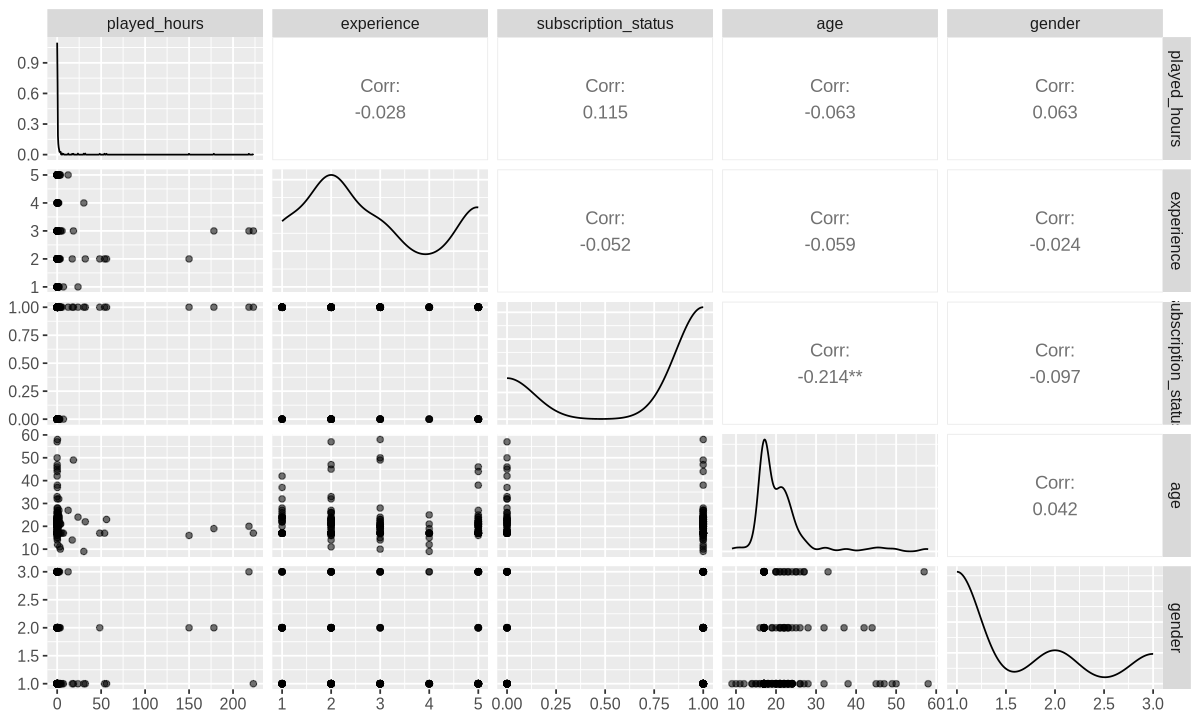

In [6]:
options(repr.plot.height = 6, repr.plot.width = 10)
# Using ggpairs, we can observe the relationships between variables to discern which ones are best to focus on.
players_num |> ggpairs(aes(alpha = 0.05)) + theme(text = element_text(size = 12)) 

###### GGpair plot observations
Despite low correlation between all variables, a closer look at the plots reveals some variables of interest regarding played_hours
1. Unsubscribed players are seemingly never likely to log a significant amount of hours played
2. Experience levels 1 and 5 (Beginners and Veterans) are also unlikely to log hours played, and 2 and 4 (Amatuers and Regulars) are most likely to log significant hours
3. Ages 30 to 60 are unlikely to log many played hours with most likely being around age 20

Based on these observations our analysis will will narrow our research question to focus on the predictors: `experience`, `subscription_status`, and `age`.

##### **PLANNED ANALYSIS**
This study employs uses a density plot to visualize any unknown groupings (player types) within data of non-players. Then we focus on building a linear regression model on players that aiming to predict their `played_hours`.

##### **Density Plot of Non-Players**

In [35]:
# Wrangling players_num for clustering non-players
non_player_data <- players_num |> mutate(player = case_when(played_hours == 0 ~ TRUE, played_hours > 0 ~ FALSE)) |> select(player, subscription_status, experience, age)

###### _FIGURE 3_: DENSITY PLOT ON NON-PLAYERS

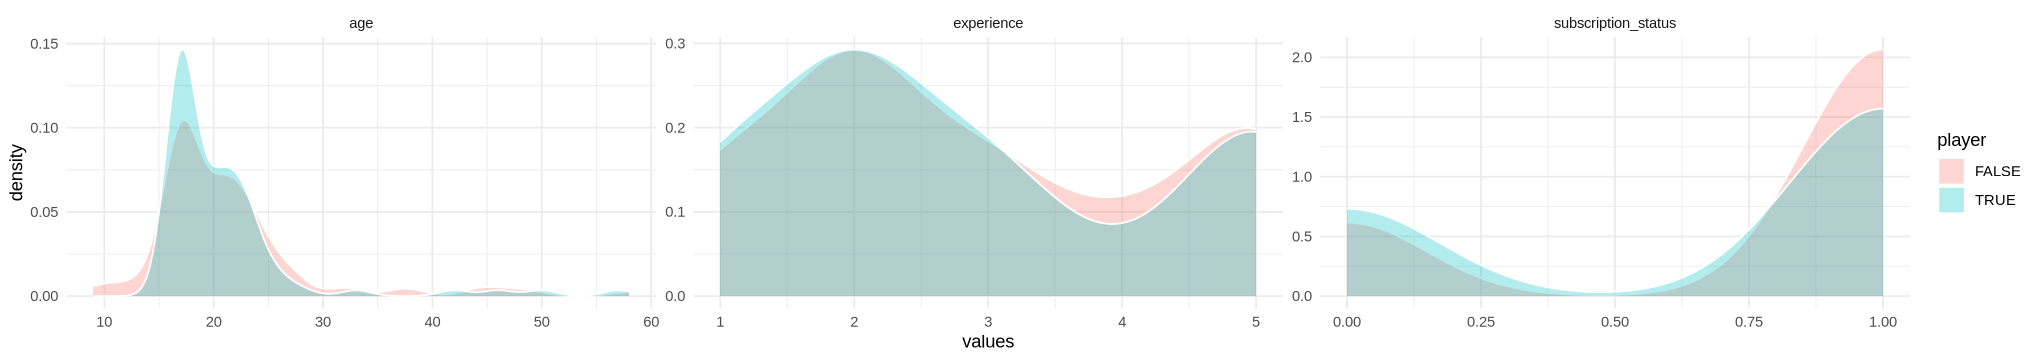

In [41]:
options(repr.plot.height = 3, repr.plot.width = 17)
non_player_data |> pivot_longer(cols = -player, names_to = "category", values_to = "values") |>
    ggplot(aes(fill = player, values)) +
        geom_density(alpha = 0.3, colour = 'white') +
        facet_wrap(facets = vars(category), scales = 'free') +
        theme(text = element_text(size = 20)) + theme_minimal()

###### NON PLAYERS
The density plot shows overall in all chosen predictors. Therefore, there are no evident distinctions between players who log zero hours and those who play. Given our research question moving forward, the analysis uses a data set without non-players.

#### **Results** <a name="results"></a>

#### **Linear Regression** <a name="lin.reg"></a>

In [42]:
# Wrangling players_num for lin.reg on all_players by removing players who played for less than 0.1 hours and who did not contribute to the data collection
all_player_data <- players_num |> filter(played_hours != 0.0) |> select(played_hours, subscription_status, experience, age)

###### **SPLITING THE DATASET**
We split our data into training and testing sets, with 75% being used to train our model and 25% being used to test, we also make sure our dependent variable, amount_played, is evenly distributed between both our testing and training sets. We also remove players who did not contribute any data as we are only using regression to identify trends in played hours amongst users who actually played.

In [61]:
set.seed(20)
# Spliting the data into a testing and training set
players_data_split <- initial_split(all_player_data, prop = 0.75, strata = played_hours)
players_data_training <- training(players_data_split)
players_data_testing <- testing(players_data_split)

###### **FORWARD SELECTION**
First we select the model which has the fewest irrelevant variables using forward selection to find the best subset of predictors. The commented out functions were used to identify the model with the highest explanatory power, which was model three, with the independent variables being experience and subscription status. 

In [106]:
# from the null to the complete model
m1 <- lm(played_hours ~ 1,                                       data = players_data_training)
m2 <- lm(played_hours ~  experience,                             data = players_data_training)
m3 <- lm(played_hours ~  experience + subscription_status,       data = players_data_training)
m4 <- lm(played_hours ~  experience + subscription_status + age, data = players_data_training)

###### _FIGURE 4_: FORWARD SELECTION ... MODEL COMPARISON

In [110]:
data.frame( m1 = summary(m1)$adj.r.squared, m2 = summary(m2)$adj.r.squared, m3 = summary(m3)$adj.r.squared, m4 = summary(m4)$adj.r.squared)

m1,m2,m3,m4
<dbl>,<dbl>,<dbl>,<dbl>
0,-0.005551553,0.001372834,-0.002259501


###### **CREATING THE LINEAR MODEL**
Using the linear model with the fewest irrelevant predictors, we identified during our forward selection, 

In [111]:
set.seed(20)
lm_spec <- linear_reg() |> 
    set_engine("lm") |> 
    set_mode("regression")

# setting a recipe with experience and subscription as the predictor variables
lm_recipe <- recipe(played_hours ~ experience + subscription_status, players_data_training) 
lm_fit <- workflow() |> 
    add_recipe(lm_recipe) |> 
    add_model(lm_spec) |> 
    fit(players_data_training)

# cross validation to make sure our fit is optimal, then collect the metrics on our training data
folds <- vfold_cv(players_data_training, v = 15)
cv_results <- lm_fit |> 
    fit_resamples(resamples = folds,
                  metrics = metric_set(rmse, mae, rsq),
                  control = control_resamples(save_pred = TRUE)) |>
    collect_metrics()

# Collecting coefficients and test statistics
coeffs <- lm_fit |> extract_fit_parsnip() |> tidy()

###### _FIGURE 5_: CROSS VALIDATION

In [112]:
cv_results

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
mae,standard,10.2281760,15,2.24219133,Preprocessor1_Model1
rmse,standard,17.2727577,15,5.64747681,Preprocessor1_Model1
rsq,standard,0.1120315,15,0.05465618,Preprocessor1_Model1


###### _FIGURE 6_: COEFFICIENTS and TEST STATISTICS

In [113]:
coeffs

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.8717124,6.753987,0.2771270,0.7820856
experience,-0.4739576,1.619343,-0.2926852,0.7701900
subscription_status,7.3414145,5.202167,1.4112224,0.1603663


###### **TESTING THE LINEAR MODEL**
Using test data through the trained and fitted model and collect the metrics on how accurately we can use our model to predict outputs. 

In [118]:
lm_test_results <- lm_fit |> predict(players_data_testing) |> bind_cols(players_data_testing) |> metrics(truth = played_hours, estimate = .pred) |> print()

# A tibble: 3 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard     30.8   
2 rsq     standard      0.0102
3 mae     standard     10.0   


##### Regression Line
Based on FIG 6, the linear model equation is the following
##### **Predicted played hours = 1.8717124 + -0.473958 * experience + 7.341414 * subscription_status**

###### _FIGURE 7_: FIT ON TESTING DATA

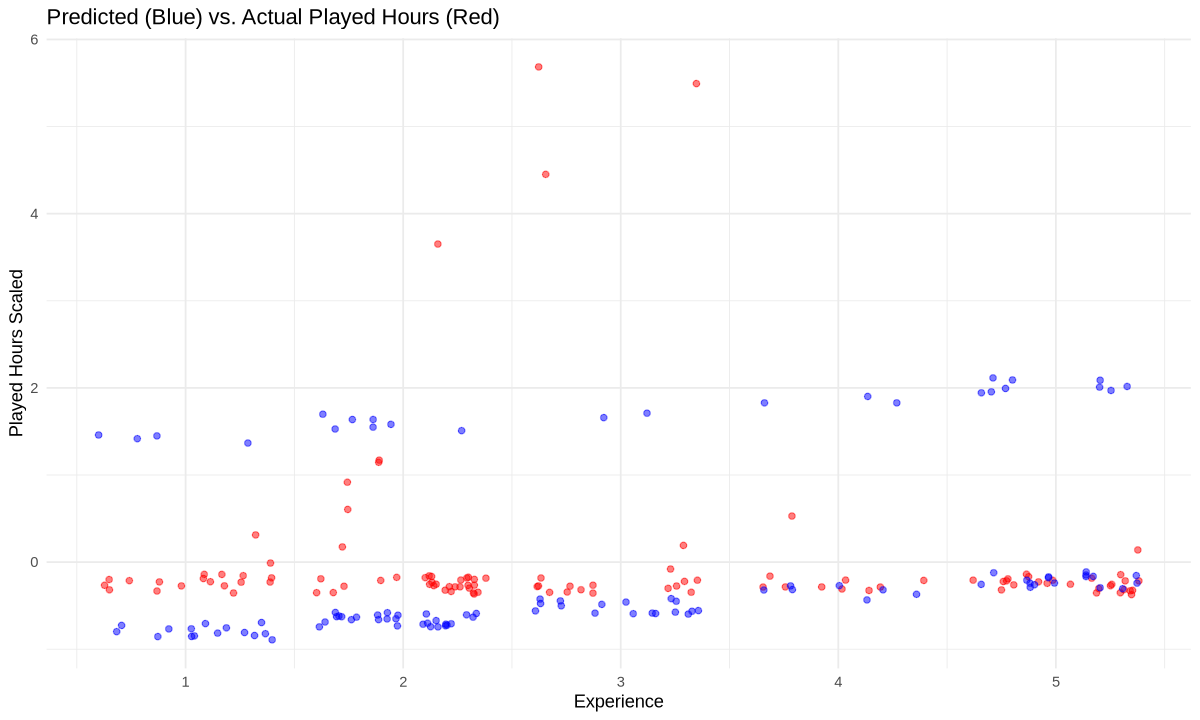

In [266]:
options(repr.plot.height = 6, repr.plot.width = 10)
preds <- lm_fit |> predict(all_player_data) |> bind_cols(all_player_data) |> mutate(.pred = scale(-.pred), played_hours = scale(played_hours))

ggplot(preds, aes(x = experience)) + 
    geom_point(aes(y = played_hours), position = position_jitter(height = 0.1), alpha = 0.5, color = "red")  +
    geom_point(aes(y = .pred), position = position_jitter(height = 0.1), alpha = 0.5, color = "blue") +
    labs(x = "Experience", y = "Played Hours Scaled", title = "Predicted (Blue) vs. Actual Played Hours (Red)") +
                scale_color_brewer(palette = "Dark2") +
                theme(text = element_text(size = 15)) +
    theme_minimal()

#### **Discussion** <a name="discussion"></a>  

##### **Summarized Results:**
Our analysis showed that individual player characteristics can only weakly predict the hours logged on the PLAI Minecraft server. Pairwise visual inspection suggested weak relationships among experience, subscription_status, age, and played_hours, with noticeable clustering when considering the broader patterns in the data. Within that clustering framework, there were three groups: a younger, more experienced, mostly subscribed cluster with relatively higher mean played hours, a younger, less experienced cluster with moderate hours; and a small, older cluster with very low mean played hours.
The linear regression models using experience, subscription status, gender, and age as predictors explained a small proportion of the variability in played hours (R-squared around 0.05), and only the “Regular” experience level showed a statistically significant positive association with played hours.

##### **Did Our Expectations Match?**
These findings partially matched the expectations formed during exploratory data analysis. Data contribution in the form of hours played is multifactorial and would not be able to be explained by a few variables. The GGpairs plots suggested weak linear relationships between the predictors and played hours, which is consistent with the R-squared values observed in the regression model.It was surprising that subscription status and most experience levels (Beginner, Pro, Veteran) were not significant predictors, and that age had limited explanatory power despite the apparent concentration of active players around age 20. The clustering results matched our expectation that groups of players share characteristic profiles rather than following a single global linear pattern. 

##### **Potential Impacts**
There are various potential impacts of these findings for PLAI. Firstly, they suggest that simple demographic or self-reported characteristics are not sufficient for accurately predicting individual data contribution, which limits the effectiveness of highly targeted recruitment solely based on experience, subscription, gender, or age. Second, If validated, the clustering results could inform and improve targeted engagement strategies. The identified clusters provide a more practical way to think about outreach: PLAI could prioritize players who resemble the high-yield cluster (younger, more experienced, more likely subscribed) for engagement campaigns, while using different strategies for low-yield groups, such as older or less engaged players, if PLAI wishes to broaden participation.The finding that experience level interacts with data contribution in a limited way suggests that rewarding experience alone may not significantly boost hours logged. Instead, a combination of factors per cluster could be more effective.

##### **Limitations and Future Directions** 
These results also raise several future questions. Since a large proportion of players log zero hours, a more appropriate modeling framework might separate the decision to play at all from the amount of time played. The analyses also relied on a relatively small sample with many categories collapsed (e.g., combining various non-Male/Female gender identities into a single “Other” category), which may influence the strength of the findings.  Additional variables could be collected, such as in-game behavior, social interactions, time-of-day usage, or even prior gaming habits, to improve prediction of played hours beyond the limited demographic and self-reported attributes.  Finally, future work could compare different clustering methods and assess cluster stability more formally, as well as test whether the same clusters and patterns appear on other PLAI or external Minecraft servers.

#### **References** <a name="references"></a>
[1]  Smith, A. (2025, January 21). Plaicraft.ai launch. Pacific Laboratory for Artificial Intelligence. https://plai.cs.ubc.ca/2023/09/27/plaicraft/  
[2]  James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. 2013. An Introduction to Statistical Learning. 1st ed. Springer. https://www.statlearning.com/. 